### Analysis of Physicell NLC-CLL model

In [1]:
import anndata as ad  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pcdl

#### Load data

In [3]:
dir_output = '../output/'
mcdsts = pcdl.TimeSeries(dir_output, settingxml="../config/NLC_CLL.xml") 

reading: ../output/NLC_CLL.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: ../output/output00000000.xml
working on metadata ...
working on mesh data ...
reading: ../output/initial_mesh0.mat
working on microenvironment data ...
reading: ../output/output00000000_microenvironment0.mat
parsing: anti-apoptotic_factor data
parsing: debris data
working on discrete cell data ...
reading: ../output/output00000000_cells.mat
working on graph data ...
reading: ../output/output00000000_cell_neighbor_graph.txt
reading: ../output/output00000000_attached_cells_graph.txt
done!

reading: ../output/NLC_CLL.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: ../output/output00000001.xml
working on metadata ...
working on mesh data ...
reading: ../output/initial_mesh0.mat
working on microenvironment data ...
reading: ../output/output00000001_microenvironment0.mat
par

KeyboardInterrupt: 

#### Extract time series information

In [ ]:
cell_states = mcdsts.get_cell_df_states(allvalues=True,states=2)
voxel_states = mcdsts.get_conc_df_states(allvalues=True,states=2)

#### Extract time step

In [31]:
timesteps = mcdsts.get_mcds_list()

Count dead cells (Option A)

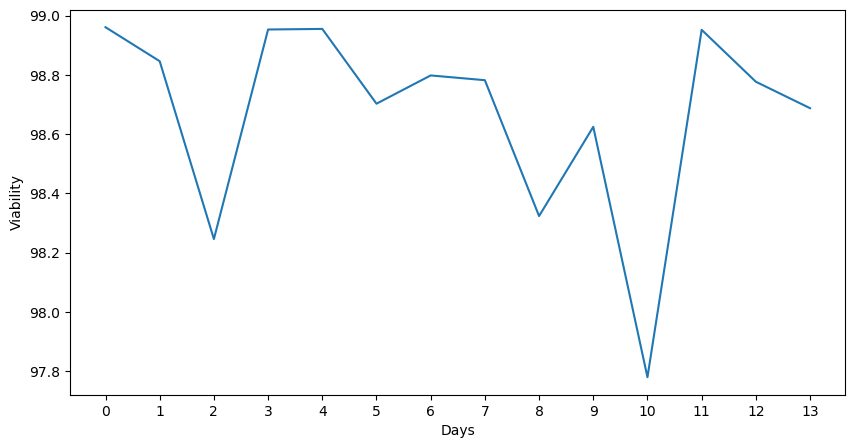

In [32]:
initial = timesteps[0].get_cell_df(states=2)
CLL_initial = len(initial[(initial['cell_type']=="cancer")])
apoptotic_initial = len(initial[(initial['cell_type']=="apoptotic")])

positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

alive = [CLL_initial]
dead = [0]
apoptotic = [apoptotic_initial]
for i in range(1, len(positions)):
  step = timesteps[positions[i]].get_cell_df(states=2)
  number_alive = len(step[(step['cell_type']=='cancer')&(step['dead']==False)])
  number_apoptotic = len(step[(step['cell_type']=='apoptotic')&(step['dead']==False)])
  number_dead = len(step[step['dead']==True])
  alive.append(number_alive)
  dead.append(number_dead)
  apoptotic.append(number_apoptotic)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_apoptotic = pd.Series(apoptotic, name = "Cells_apoptotic")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#viability at time t =  CLL alive at time t / (CLL alive + CLL apoptotic + CLL dead) at time t
viability = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_apoptotic[i]+CLL_dead[i]))*100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

fig, ax = plt.subplots(figsize=(10, 5))
viability.T.plot(kind='line', xlabel='Days', ylabel='Viability', logy=False, ax=ax)  
ax.set_xticks(viability.index)
plt.show()

#### Concentration

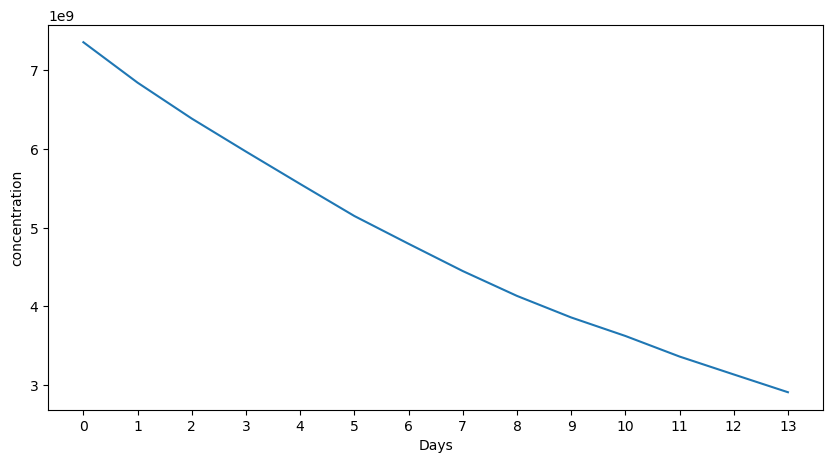

In [28]:
#Cells alive / Volume
volumen = 0.0000648 #cm3 648x10**-7

concentration = []
for i in CLL_alive:
    number = round(i/volumen,2)*100
    concentration.append(number)

concentration = pd.Series(concentration, name = "CLL concentration")

fig, ax = plt.subplots(figsize=(10, 5))
concentration.T.plot(kind='line', xlabel='Days', ylabel='concentration', logy=False, ax=ax)  
ax.set_xticks(concentration.index)
plt.show()

#### Load experimental data

In [14]:
experimental = pd.read_csv('patient_specific_data.tsv', sep='\t')
experimental_fused = pd.read_csv('filtered_fused_9patients.csv')

#### Viability

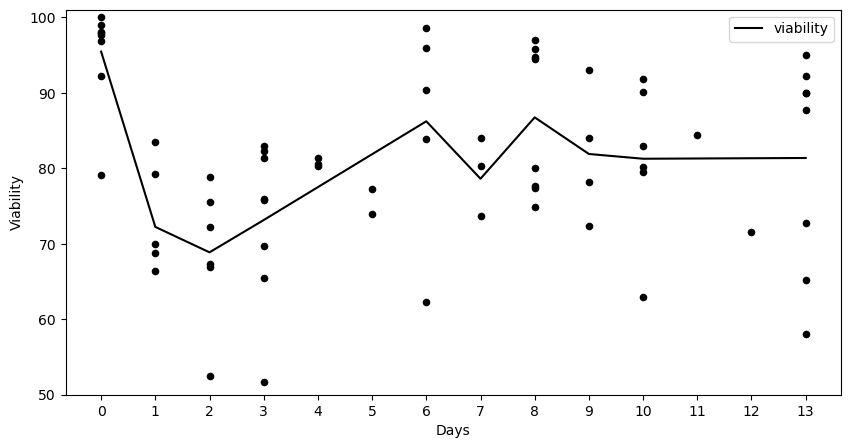

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

experimental.plot(x='Day', y='viability', kind='scatter', xlabel='Days', ylabel='Viability', ylim=(50, 101), ax=ax, color='black')
experimental_fused.plot(x='Day', y='viability', kind='line', xlabel='Days', ylabel='Viability', ax=ax, logy=False, color='black')
ax.set_xticks(experimental['Day'].unique())
plt.show()

#### Concentration

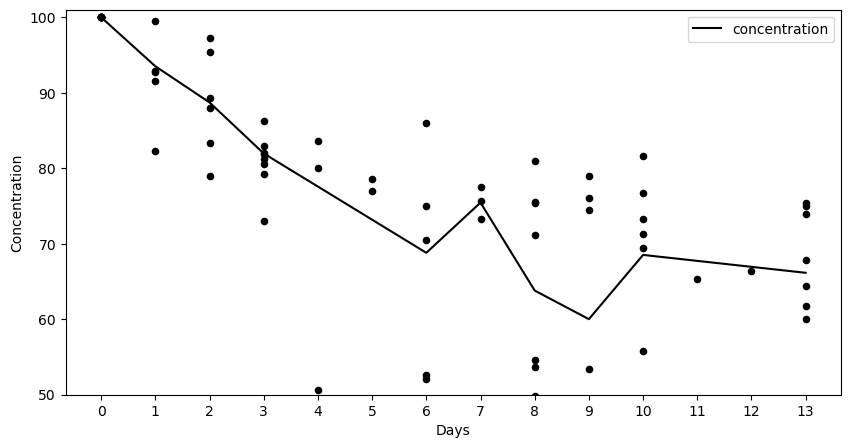

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

experimental.plot(x='Day', y='concentration', kind='scatter', xlabel='Days', ylabel='Concentration', ylim=(50, 101), ax=ax, color='black')
experimental_fused.plot(x='Day', y='concentration', kind='line', xlabel='Days', ylabel='Concentration', ax=ax, logy=False, color='black')
ax.set_xticks(experimental['Day'].unique())

plt.show()

Count dead cells (Option B)

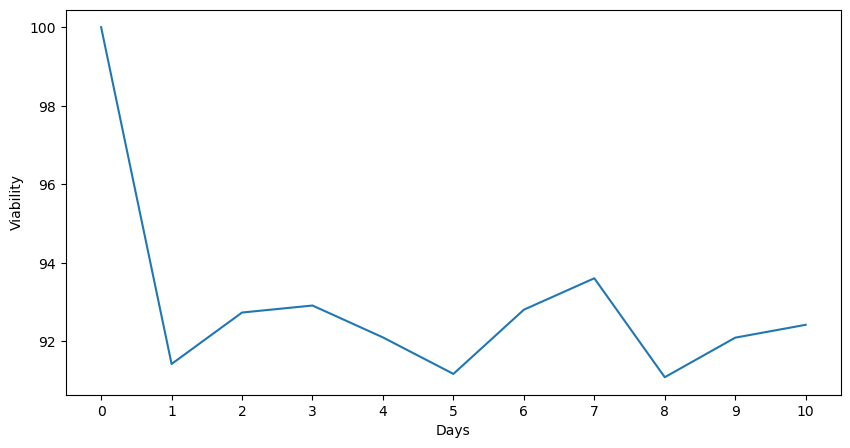

In [30]:
initial = timesteps[0].get_cell_df(states=2)
CLL_initial = len(initial[(initial['cell_type']=="cancer_cells")|(initial['cell_type']=="apoptotic")])

positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

alive = [CLL_initial]
dead = [0]
for i in range(1, len(positions)-2):
  step = timesteps[positions[i]].get_cell_df(states=2)
  number_alive = len(step[((step['cell_type']=='cancer_cells')|(step['cell_type']=='apoptotic'))&(step['dead']==False)])
  cells_x = step.index

  dead_cells = len(step[step['dead']==True])

  step2 = timesteps[positions[i+1]].get_cell_df(states=2)
  cells_y = step2.index
  difference = len(np.setdiff1d(cells_x, cells_y)) 

  number_dead = dead_cells+difference
  alive.append(number_alive)
  dead.append(number_dead)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#print(CLL_alive)
#print(CLL_dead)

#viability =  initial CLL number - dead cell number / initial CLL number
viability = []
for i in range(len(CLL_alive)-1):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_dead[i]))*100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

fig, ax = plt.subplots(figsize=(10, 5))
viability.T.plot(kind='line', xlabel='Days', ylabel='Viability', logy=False, ax=ax)  
ax.set_xticks(viability.index)
plt.show()

Count dead cells (Option C)

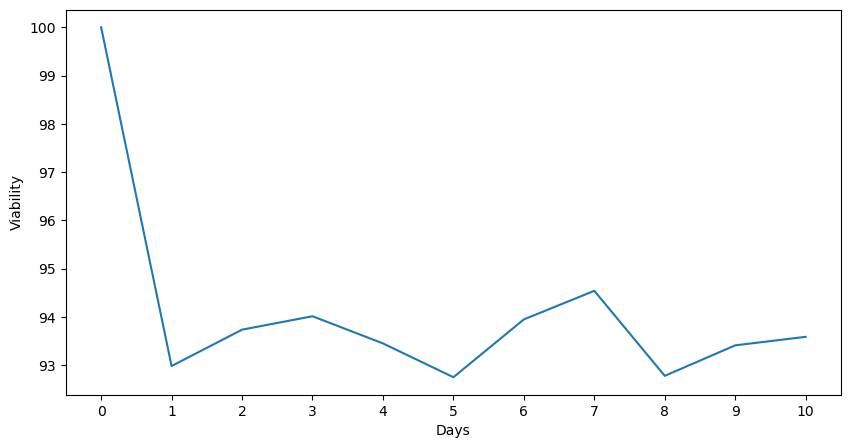

In [31]:
initial = timesteps[0].get_cell_df(states=2)
CLL_initial = len(initial[(initial['cell_type']=="cancer_cells")|(initial['cell_type']=="apoptotic")])

positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

alive = [CLL_initial]
dead = [0]
for i in range(1, len(positions)-2):
  step = timesteps[positions[i]].get_cell_df(states=2)
  number_alive = len(step[((step['cell_type']=='cancer_cells')|(step['cell_type']=='apoptotic'))&(step['dead']==False)])
  cells_x = step.index

  step2 = timesteps[positions[i+1]].get_cell_df(states=2)
  cells_y = step2.index
  number_dead = len(np.setdiff1d(cells_x, cells_y))

  alive.append(number_alive)
  dead.append(number_dead)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#print(CLL_alive)
#print(CLL_dead)

#viability =  initial CLL number - dead cell number / initial CLL number
viability = []
for i in range(len(CLL_alive)-1):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_dead[i]))*100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

fig, ax = plt.subplots(figsize=(10, 5))
viability.T.plot(kind='line', xlabel='Days', ylabel='Viability', logy=False, ax=ax)  
ax.set_xticks(viability.index)
plt.show()